In [1]:
from netCDF4 import Dataset
import numpy as np
from glob import glob


from pymbar import timeseries as ts

import matplotlib.pyplot as plt
%matplotlib inline

## Equilibrium sampling
### Viewing the trace of the number of salt

Acceptance probabilty = 0.403063794189
Acceptance probabilty = 0.487483062193
Acceptance probabilty = 0.430082090616
Acceptance probabilty = 0.125356668083
Acceptance probabilty = 0.00894159981983
Acceptance probabilty = 0.0024514181504
Acceptance probabilty = 0.0
Acceptance probabilty = 0.0
Acceptance probabilty = 0.0
Acceptance probabilty = 0.0
Acceptance probabilty = 0.0
Acceptance probabilty = 0.0
Acceptance probabilty = 0.0


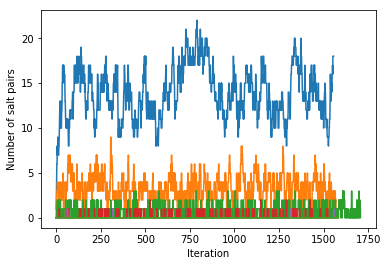

In [2]:
results_folders = glob('deltamu_3*')

burnin = 100

mean_salt = []
deltachem = []
acceptance_prob = []
for folder in results_folders:
    ncfile = Dataset(folder + '/out.nc')
    naccepted = ncfile.groups['Sample state data']['naccepted'][0::4]
    naccepted = naccepted.reshape(naccepted.shape[0])
    print('Acceptance probabilty =',np.mean(naccepted) / len(naccepted))
    acceptance_prob.append(np.mean(naccepted) / len(naccepted))
    deltachem.append(ncfile.groups['Control parameters']['delta_chem'][0])
    nsalt = ncfile.groups['Sample state data']['species counts'][0::4][:,1]
    mean_salt.append(np.mean(nsalt[burnin:]))
    plt.plot(nsalt)

plt.xlabel('Iteration')
plt.ylabel('Number of salt pairs')
plt.show()

## Viewing histograms of concentrations

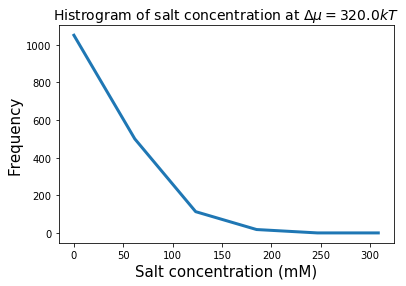

In [4]:
burnin = 100
ncfile = Dataset('deltamu_320.0/out.nc')
nsalt = ncfile.groups['Sample state data']['species counts'][burnin:-1][:,1]
volume = ncfile.groups['Sample state data']['volume'][burnin:-1][:,0]
ncfile.close()
concentration = nsalt / volume
bins = np.arange(nsalt.min(),nsalt.max()+4) / np.mean(volume)
hist, edges = np.histogram(concentration, bins)

concentrations = 1.E4 * edges[0:-1] / 6.033 

plt.plot(concentrations, hist, lw=3)
plt.title('Histrogram of salt concentration at $\Delta \mu = 320.0 kT$', fontsize=14)
plt.xlabel('Salt concentration (mM)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

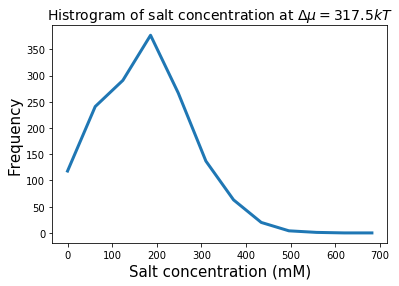

In [7]:
burnin = 200
ncfile = Dataset('deltamu_317.5/out.nc')
nsalt = ncfile.groups['Sample state data']['species counts'][burnin:-1][:,1]
volume = ncfile.groups['Sample state data']['volume'][burnin:-1][:,0]
concentration = nsalt / volume
ncfile.close()
bins = np.arange(nsalt.min(),nsalt.max()+4) / np.mean(volume)
hist, edges = np.histogram(concentration, bins)

concentrations = 1.E4 * edges[0:-1] / 6.033 

plt.plot(concentrations, hist, lw=3)
plt.title('Histrogram of salt concentration at $\Delta \mu = 317.5 kT$', fontsize=14)
plt.xlabel('Salt concentration (mM)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

## Plotting the average number of salt molecules vs chemical potential

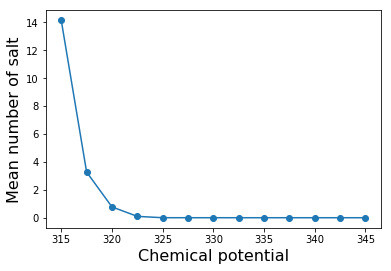

In [3]:
mean_salt = np.array(mean_salt)
deltachem = np.array(deltachem)

plt.scatter(deltachem, mean_salt)
plt.plot(deltachem, mean_salt)
plt.xlabel('Chemical potential', fontsize=16)
plt.ylabel('Mean number of salt', fontsize=16)
plt.show()

In [7]:
mean_salt

array([  1.41388081e+01,   3.27501800e+00,   7.76315789e-01,
         9.65166909e-02,   1.44404332e-03,   7.84313725e-04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

### Same plot as above but with concentration instead

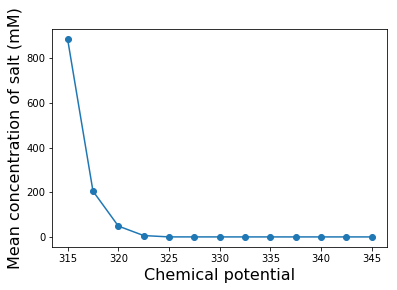

In [5]:
nwats = 887.
mean_concetration = 55.5 * mean_salt / nwats * 1000 #(in mM)

plt.scatter(deltachem, mean_concetration)
plt.plot(deltachem, mean_concetration)
plt.xlabel('Chemical potential', fontsize=16)
plt.ylabel('Mean concentration of salt (mM)', fontsize=16)
plt.show()

### Viewing $\Delta \mu=317.5$

Mean salt number = 0.77
Variance in salt number = 0.47


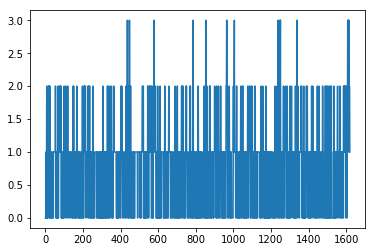

In [5]:
ncfile = Dataset('deltamu_320.0/out.nc')
nsalt = ncfile.groups['Sample state data']['species counts'][0::4][:,1]
plt.plot(nsalt)

print('Mean salt number = {0:.2f}'.format(np.mean(nsalt)))
print('Variance in salt number = {0:.2f}'.format(np.var(nsalt)))

## Calculating the free energy to insert salt with BAR

In [6]:
def add_salt_factor(nwats, nsalt):
    """
    The proposal probability for selecting two water molecules to swap with an anion and cation. 
    """
    return np.log(1.0 * nwats * (nwats - 1) / (nsalt + 1) / (nsalt + 1))

def remove_salt_factor(nwats, nsalt):
    """
    The proposal probability for selecting an anion and cation and swapping with two water molecules. 
    """
    return np.log(1.0 * nsalt * nsalt / (nwats + 1) / (nwats + 2))

In [7]:
proposals = ncfile.groups['Sample state data']['proposal'][0::4]
proposals = proposals.reshape(proposals.shape[0],2)
protocol_works = ncfile.groups['Sample state data']['cumulative work'][0::4]
work = protocol_works[:,0,-1]

### For a salt pair in an empty box

In [8]:
from pymbar import bar, timeseries

work = protocol_works[:,0,-1]

nwats = 887
work_add = []
work_remove = []
for proposal, work in zip(proposals, work):
    if np.all(proposal == np.array([0, 1])):
        work_add.append(work -  add_salt_factor(nwats, 0))
    elif np.all(proposal == np.array([1, 0])):
        work_remove.append(work -  remove_salt_factor(nwats - 1, 1))
        
work_add = np.array(work_add)
work_remove = np.array(work_remove)
results = bar.BAR(work_add, work_remove, compute_uncertainty=True)
print('Free energy to insert 1 salt pair = {0:.1f} +/- {1:.1f} kT'.format(results[0], results[1]))

Free energy to insert 1 salt pair = -320.1 +/- 0.1 kT


### For a salt pair in a box with one salt pair already present

In [9]:
work = protocol_works[:,0,-1]

nwats = 887
work_add = []
work_remove = []
for proposal, work in zip(proposals, work):
    if np.all(proposal == np.array([1, 2])):
        work_add.append(work -  add_salt_factor(nwats - 1, 1))
    elif np.all(proposal == np.array([2, 1])):
        work_remove.append(work -  remove_salt_factor(nwats - 2, 2))
work_add = np.array(work_add)
work_remove = np.array(work_remove)
results = bar.BAR(work_add, work_remove, compute_uncertainty=True)
print('Free energy to insert 1 salt pair = {0:.1f} +/- {1:.1f} kT'.format(results[0], results[1]))

Free energy to insert 1 salt pair = -318.6 +/- 0.1 kT
